# Nvidia AI Chip Sales

This notebook estimates the total volume of shipments of Nvidia's leading AI chips over time, from 2022 on
See "AI Chip Sales" on epoch.ai for full documentation and more information

# Config

In [ ]:
# Install required packages
!pip install squigglepy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


In [63]:
# Squigglepy documentation: https://github.com/rethinkpriorities/squigglepy
import squigglepy as sq
import numpy as np
import matplotlib.pyplot as plt
from squigglepy.numbers import K, M, B
from pprint import pprint
import pandas as pd

sq.set_seed(42)
np.random.seed(42)

In [ ]:
# Helper Functions
# ================

from scipy import stats

# alternative to squigglepy
def generate_lognormal_from_percentiles(x_lower, x_upper, p_lower, p_upper, n=10000):
    """
    Generate lognormal distribution samples from percentile constraints.

    Args:
        x_lower: Lower bound value at p_lower percentile
        x_upper: Upper bound value at p_upper percentile
        p_lower: Lower percentile (e.g., 20 for 20th percentile)
        p_upper: Upper percentile (e.g., 80 for 80th percentile)
        n: Number of samples to generate

    Returns:
        numpy array of lognormal samples
    """
    z_lower = stats.norm.ppf(p_lower / 100)
    z_upper = stats.norm.ppf(p_upper / 100)

    mu = (np.log(x_lower) * z_upper - np.log(x_upper) * z_lower) / (z_upper - z_lower)
    sigma = (np.log(x_upper) - np.log(x_lower)) / (z_upper - z_lower)

    return np.random.lognormal(mean=mu, sigma=sigma, size=n)

# wrapper for sq.to, with default credibility of 80% (library default is 90)
def sq_distribution(x_lower, x_upper, credibility=80, lclip = None, rclip = None):
    return sq.to(x_lower, x_upper, credibility, lclip, rclip)


def print_percentile_results(samples, title="Percentiles", percentiles=[25, 50, 75]):
    """Print formatted percentile results."""
    results = sq.get_percentiles(samples, percentiles=percentiles, digits=0)

    print(f"{title}:")
    for percentile, value in results.items():
        print(f"  {percentile}: {value:,}")

    return results


def fy_to_decimal_year(fy_string):
    """
    Convert Nvidia fiscal year quarter string to decimal year.

    Nvidia's fiscal year ends in January, so:
    - FY26 Q1 ends April 2025 (Q1: Feb-Apr)
    - FY26 Q2 ends July 2025 (Q2: May-Jul)
    - FY26 Q3 ends October 2025 (Q3: Aug-Oct)
    - FY26 Q4 ends January 2026 (Q4: Nov-Jan)

    Args:
        fy_string (str): Fiscal year string like "FY23Q1" or "FY26Q2"

    Returns:
        float: Decimal year representing the end date of the quarter

    """
    # Parse the fiscal year and quarter
    fy_part = fy_string[:4]  # "FY26"
    q_part = fy_string[4:]   # "Q1"

    # Extract fiscal year number (last 2 digits)
    fy_num = int(fy_part[2:])

    # Convert 2-digit year to 4-digit year
    # Assuming fiscal years 00-99 map to 2000-2099
    if fy_num < 50:  # Adjust this threshold as needed
        fiscal_year = 2000 + fy_num
    else:
        fiscal_year = 1900 + fy_num

    # Extract quarter number
    quarter = int(q_part[1:])

    # Map quarters to their end months and approximate decimal positions
    quarter_end_map = {
        1: (4, 0.32),   # Q1 ends in April (4/12 ≈ 0.32)
        2: (7, 0.57),   # Q2 ends in July (7/12 ≈ 0.57)
        3: (10, 0.82),  # Q3 ends in October (10/12 ≈ 0.82)
        4: (1, 0.07)    # Q4 ends in January of next calendar year
    }

    end_month, decimal_fraction = quarter_end_map[quarter]

    # For Q4, the calendar year is the fiscal year
    # For Q1-Q3, the calendar year is fiscal year - 1
    if quarter == 4:
        calendar_year = fiscal_year
    else:
        calendar_year = fiscal_year - 1

    return calendar_year + decimal_fraction

# Chips Data/Config

In [ ]:
# Chip performance in 8-bit TFLOP/s without sparsity
CHIP_FLOPS = {
    'A100': 624,
    'A800': 624,
    'H100': 1979,
    'H100/H200': 1979,
    'H800': 1979,
    'H20': 296,       
    'B200': 5000,
    'B300': 5000     
}

CHIP_TYPES = ['A100', 'H100/H200', 'A800', 'H800', 'H20','B200', 'B300']

# Colors for visualization - maps chip types to matplotlib colors
CHIP_COLORS = {
    'A100': 'lightcoral',
    'H100/H200': 'steelblue',
    'H20': 'orange',
    'A800': 'sienna',
    'H800': 'firebrick',
    'B200': 'mediumseagreen',
    'B300': 'seagreen',
}

CHIP_ECONOMICS = {
    # What share of Nvidia's "Compute" revenue is actual compute hardware, vs
    # cloud compute or software products
    'hardware_share_of_compute': (0.96, 0.99),

    'H100/H200_price_range': (20, 30),
    'A100_price_range': (10, 15),
    'H20_price_range': (10, 15),
    'A800_price_range': (10, 15),
    'H800_price_range': (20, 30),
    'B200_price_range': (33, 42),
    'B300_price_range': (33, 42),
}

def convert_to_h100_equivs(chip_type, quantity):
  return quantity * (CHIP_FLOPS[chip_type] / CHIP_FLOPS['H100/H200'])

# Nvidia total sales

In [67]:
# source-of-truth spreadsheet here:
csv_url = "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=1819303346"
chip_prices_df = pd.read_csv(csv_url).set_index('Year')

chip_prices_df.head()

,A100 low,A100 high,Notes,H100 low,H100 high,Geomean,Notes.1,B200 low,B200 high,Geomean.1,...,Geomean.2,Notes.3,H20 low,H20 high,Geomean.3,A800 low,A100 high.1,Notes.4,H800 low,H800 high
Year,,,,,,,,,,,,,,,,,,,,,
2022,10000,15000,NaN,25000,35000,"$29,580",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10000.0,15000.0,NaN,NaN,NaN
2023,10000,15000,NaN,25000,30000,"$27,386",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10000.0,15000.0,NaN,25000.0,35000.0
2024,10000,15000,NaN,23000,30000,"$26,268",NaN,33000.0,42000.0,"$37,229",...,NaN,NaN,10000.0,15000.0,"$12,247",NaN,NaN,NaN,NaN,NaN
2025,10000,15000,NaN,20000,27000,"$23,238",NaN,33000.0,42000.0,"$37,229",...,"$43,151",NaN,10000.0,13000.0,"$11,402",NaN,NaN,NaN,NaN,NaN


In [68]:
nvda_revenue_df = pd.read_csv("https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=0").set_index('Quarter')

nvda_revenue_df.head(5)

,Start Date,End Date,Total revenue,Datacenter revenue,Datacenter share,Networking revenue,Compute share of DC,Compute revenue,A100 share,A800 share,H100/H200 share,H800 share,H20 share,B200 share,B300 share,Notes,Press release,CFO commentary link,Sum of shares
Quarter,,,,,,,,,,,,,,,,,,,
FY23Q1,2022-01-31,2022-05-01,8.29,3.75,0.452,NaN,0.750,2.81,1.00,0.00,0.0,0.0,0.0,0.0,0.0,"Networking revenue for 2022 is not broken out,...",https://nvidianews.nvidia.com/news/nvidia-anno...,NaN,1
FY23Q2,2022-05-02,2022-07-31,6.70,3.81,0.569,NaN,0.750,2.86,1.00,0.00,0.0,0.0,0.0,0.0,0.0,Note that all rows ignore lower-grade data cen...,https://nvidianews.nvidia.com/news/nvidia-anno...,NaN,1
FY23Q3,2022-08-01,2022-10-30,5.93,3.83,0.646,NaN,0.750,2.87,0.90,0.00,0.1,0.0,0.0,0.0,0.0,"""Started shipping flagship H100 "" https://s201...",https://nvidianews.nvidia.com/news/nvidia-anno...,NaN,1
FY23Q4,2022-10-31,2023-01-29,6.05,3.62,0.598,NaN,0.750,2.72,0.31,0.19,0.5,0.0,0.0,0.0,0.0,"""H100 revenue was already much higher than tha...",https://investor.nvidia.com/news/press-release...,NaN,1
FY24Q1,2023-01-30,2023-04-30,7.19,4.28,0.595,0.927,0.783,3.35,0.21,0.09,0.6,0.1,0.0,0.0,0.0,No new info from Nvidia on Ampere/Hopper trans...,https://investor.nvidia.com/news/press-release...,https://s201.q4cdn.com/141608511/files/doc_fin...,1


## Total revenue by chip type

In [ ]:
# Calculate revenue by chip type
quarterly_revenue_df = nvda_revenue_df.copy()

revenue_totals = {}

# Uncertainty distribution for what share of compute revenue is actually hardware
hardware_share = sq_distribution(*CHIP_ECONOMICS['hardware_share_of_compute'])

# find quarterly revenue by chip 
for chip_type in CHIP_TYPES:
    quarterly_revenue_df[f'{chip_type}_revenue'] = quarterly_revenue_df['Compute revenue'] * quarterly_revenue_df[f'{chip_type} share']
    revenue_totals[chip_type] = quarterly_revenue_df[f'{chip_type}_revenue'].sum()

print("Total NVIDIA Revenue by Chip Type (Billions USD):")
for chip_type, revenue in revenue_totals.items():
    if revenue > 0:
        print(f"  {chip_type}: ${revenue:.1f}B")

# Helper function to get each chip's price distribution for given year
def get_price_distribution(chip_type, year):

    # Find the closest year in chip_prices_df
    available_years = chip_prices_df.index.tolist()
    closest_year = min(available_years, key=lambda x: abs(x - year))

    # Map chip types to their column names in chip_prices_df
    # H100/H200 uses 'H100' columns in the spreadsheet
    col_chip_name = 'H100' if chip_type == 'H100/H200' else chip_type

    # Get the low and high prices for this chip type and year
    low_col = f'{col_chip_name} low'
    high_col = f'{col_chip_name} high'

    if (low_col in chip_prices_df.columns and high_col in chip_prices_df.columns):
        low_price = chip_prices_df.loc[closest_year, low_col]
        high_price = chip_prices_df.loc[closest_year, high_col]

        if not (pd.isna(low_price) or pd.isna(high_price)):
            # Create price distribution using the low and high values
            return sq_distribution(low_price, high_price)

    # Fallback to static pricing if quarterly prices aren't available
    fallback_prices = CHIP_ECONOMICS[f'{chip_type}_price_range']

    return sq_distribution(*[x * K for x in fallback_prices])

# Calculate chip sales by type using dynamic pricing over quarters
chip_sales = {}
h100_equiv_sales = {}

# Initialize accumulated sales distributions
for chip_type in CHIP_TYPES:
    chip_sales[chip_type] = 0
    h100_equiv_sales[chip_type] = 0

# df of quarterly sales by chip type
quarterly_chip_sales = pd.DataFrame(index=quarterly_revenue_df.index)

# Process each quarter with time-specific pricing
for quarter in quarterly_revenue_df.index:
    # Get the year for this quarter using the helper function
    quarter_year = int(round(fy_to_decimal_year(quarter)))

    for chip_type in CHIP_TYPES:
        quarterly_revenue_for_chip = quarterly_revenue_df.loc[quarter, f'{chip_type}_revenue'] * B  # Convert to dollars

        if quarterly_revenue_for_chip > 0:
            # Get dynamic price distribution for this quarter and chip type
            price_dist = get_price_distribution(chip_type, quarter_year)

            # Calculate number of this chip type sold
            quarterly_sales = quarterly_revenue_for_chip * hardware_share / price_dist

            # Calculate H100-equivalent sales using the conversion function
            quarterly_equiv_sales = convert_to_h100_equivs(chip_type, quarterly_sales)

            # Accumulate sales across quarters
            chip_sales[chip_type] += quarterly_sales
            h100_equiv_sales[chip_type] += quarterly_equiv_sales

# Calculate total H100-equivalent sales
total_h100_equivs = sum(h100_equiv_sales.values())
total_samples = total_h100_equivs @ 10000

print(f"\nNVIDIA Total H100-Equivalent Sales:")
nvidia_results = print_percentile_results(total_samples, "", [10, 50, 90])

for chip in CHIP_TYPES:
    chip_samples = h100_equiv_sales[chip] @ 10000
    print_percentile_results(chip_samples, f'Total sales of {chip} in H100-equivalents', [10, 50, 90])

## Break down total chip sales by quarter

In [ ]:
quarterly_chip_quantities = pd.DataFrame(index=quarterly_revenue_df.index)

# Add decimal year column for easier analysis
quarterly_chip_quantities['decimal_year'] = [fy_to_decimal_year(quarter) for quarter in quarterly_revenue_df.index]

# Calculate quarterly quantities for each chip type
for chip_type in CHIP_TYPES:

    # Calculate quarterly revenue for this chip type
    quarterly_revenue = quarterly_revenue_df[f'{chip_type}_revenue'] * B  # Convert to dollars

    # Calculate quarterly chip quantities (accounting for price distributions)
    for quarter in quarterly_revenue_df.index:
        year = fy_to_decimal_year(quarter)
        price_dist = get_price_distribution(chip_type, year)

        if quarterly_revenue[quarter] > 0:
            quarter_revenue = quarterly_revenue[quarter]
            quarter_quantity = quarter_revenue * hardware_share / price_dist

            # Store the distribution for sampling
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_dist'] = quarter_quantity

            # Calculate median for display
            samples = quarter_quantity @ 1000
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_median'] = np.median(samples)
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_5th'] = np.percentile(samples, 5)
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_25th'] = np.percentile(samples, 25)
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_75th'] = np.percentile(samples, 75)
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_95th'] = np.percentile(samples, 95)
        else:
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_dist'] = None
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_median'] = 0
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_5th'] = 0
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_25th'] = 0
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_75th'] = 0
            quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_95th'] = 0

print("Quarterly Chip Quantities (Median Estimates):")
print("=" * 50)

# Display quarterly quantities for each chip type
for chip_type in CHIP_TYPES:
    print(f"\n{chip_type} Quarterly Sales:")
    for quarter in quarterly_revenue_df.index:
        median_qty = quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_median']
        if median_qty > 0:
            p25 = quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_25th']
            p75 = quarterly_chip_quantities.loc[quarter, f'{chip_type}_quantity_75th']
            year = quarterly_chip_quantities.loc[quarter, 'decimal_year']
            print(f"  {quarter} ({year:.1f}): {median_qty:,.0f} chips (25th-75th: {p25:,.0f} - {p75:,.0f})")

# Create summary dataframe with median and percentile values
quarterly_sales = pd.DataFrame(index=quarterly_chip_quantities.index)
quarterly_sales['decimal_year'] = quarterly_chip_quantities['decimal_year']

# Add median, 10th and 90th percentiles for each chip type
for chip in CHIP_TYPES:
    quarterly_sales[f'{chip}_quantity'] = quarterly_chip_quantities[f'{chip}_quantity_median']
    quarterly_sales[f'{chip}_quantity_5th'] = quarterly_chip_quantities[f'{chip}_quantity_5th']
    quarterly_sales[f'{chip}_quantity_95th'] = quarterly_chip_quantities[f'{chip}_quantity_95th']

print(f"\nQuarterly Summary DataFrame:")
print(quarterly_sales[['decimal_year'] + [f'{chip}_quantity' for chip in CHIP_TYPES]].round(0))

Quarterly Chip Quantities (Median Estimates):

A100 Quarterly Sales:
  FY23Q1 (2022.3): 226,248 chips (25th-75th: 199,772 - 250,913)
  FY23Q2 (2022.6): 226,776 chips (25th-75th: 203,729 - 252,828)
  FY23Q3 (2022.8): 204,902 chips (25th-75th: 184,287 - 229,156)
  FY23Q4 (2023.1): 66,968 chips (25th-75th: 60,175 - 74,521)
  FY24Q1 (2023.3): 55,963 chips (25th-75th: 49,975 - 62,547)
  FY24Q2 (2023.6): 68,891 chips (25th-75th: 61,850 - 76,410)
  FY24Q3 (2023.8): 47,096 chips (25th-75th: 42,105 - 52,183)

H100/H200 Quarterly Sales:
  FY23Q3 (2022.8): 9,735 chips (25th-75th: 8,540 - 11,294)
  FY23Q4 (2023.1): 46,055 chips (25th-75th: 40,681 - 52,847)
  FY24Q1 (2023.3): 69,146 chips (25th-75th: 59,970 - 79,696)
  FY24Q2 (2023.6): 211,055 chips (25th-75th: 184,466 - 240,498)
  FY24Q3 (2023.8): 308,095 chips (25th-75th: 269,520 - 352,601)
  FY24Q4 (2024.1): 511,389 chips (25th-75th: 442,849 - 583,776)
  FY25Q1 (2024.3): 583,409 chips (25th-75th: 502,715 - 665,294)
  FY25Q2 (2024.6): 671,285 chi

In [71]:
quarterly_chip_quantities.head(5)

,decimal_year,A100_quantity_dist,A100_quantity_median,A100_quantity_5th,A100_quantity_25th,A100_quantity_75th,A100_quantity_95th,H100/H200_quantity_dist,H100/H200_quantity_median,H100/H200_quantity_5th,...,B200_quantity_5th,B200_quantity_25th,B200_quantity_75th,B200_quantity_95th,B300_quantity_dist,B300_quantity_median,B300_quantity_5th,B300_quantity_25th,B300_quantity_75th,B300_quantity_95th
Quarter,,,,,,,,,,,,,,,,,,,,,
FY23Q1,2022.32,<Distribution> 2810000000.0 * lognorm(lognorm_...,226247.638300,170354.339508,199772.442498,250913.149541,290210.326318,None,0.000000,0.000000,...,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,0.0
FY23Q2,2022.57,<Distribution> 2860000000.0 * lognorm(lognorm_...,226776.322131,175451.551793,203729.474215,252827.821054,300539.597655,None,0.000000,0.000000,...,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,0.0
FY23Q3,2022.82,<Distribution> 2583000000.0 * lognorm(lognorm_...,204902.425445,159595.612981,184286.926105,229155.778573,266366.140915,<Distribution> 287000000.00000006 * lognorm(lo...,9735.391119,7103.862426,...,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,0.0
FY23Q4,2023.07,<Distribution> 843200000.0000001 * lognorm(log...,66968.481274,52007.241958,60175.386732,74520.934499,87693.293338,<Distribution> 1360000000.0 * lognorm(lognorm_...,46054.539994,33735.980313,...,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,0.0
FY24Q1,2023.32,<Distribution> 703500000.0 * lognorm(lognorm_m...,55962.838067,42848.837582,49975.368754,62546.961042,73040.258858,<Distribution> 2009999999.9999998 * lognorm(lo...,69146.034014,49735.776596,...,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,0.0


In [72]:
quarterly_sales.head(5)

,decimal_year,A100_quantity,A100_quantity_5th,A100_quantity_95th,H100/H200_quantity,H100/H200_quantity_5th,H100/H200_quantity_95th,A800_quantity,A800_quantity_5th,A800_quantity_95th,...,H800_quantity_95th,H20_quantity,H20_quantity_5th,H20_quantity_95th,B200_quantity,B200_quantity_5th,B200_quantity_95th,B300_quantity,B300_quantity_5th,B300_quantity_95th
Quarter,,,,,,,,,,,,,,,,,,,,,
FY23Q1,2022.32,226247.638300,170354.339508,290210.326318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FY23Q2,2022.57,226776.322131,175451.551793,300539.597655,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FY23Q3,2022.82,204902.425445,159595.612981,266366.140915,9735.391119,7103.862426,13541.412581,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FY23Q4,2023.07,66968.481274,52007.241958,87693.293338,46054.539994,33735.980313,63068.455680,41121.355693,31380.001792,52797.508069,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FY24Q1,2023.32,55962.838067,42848.837582,73040.258858,69146.034014,49735.776596,95234.243310,23808.587782,18546.637432,31372.381118,...,13676.420871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Nvidia sales by chip type

In [73]:
# Calculate total H100-equivalent chips per quarter
# Convert quarterly median quantities to H100 equivalents

# Define the baseline chip for H100-equivalent calculations
BASELINE_CHIP = 'H100/H200'

# Calculate H100 equivalents for each chip type and sum them up
quarterly_sales['Total_H100_equiv'] = sum(
    convert_to_h100_equivs(chip, quarterly_sales[f'{chip}_quantity'])
    for chip in CHIP_TYPES
)

# Calculate H100e for each individual chip type
for chip in CHIP_TYPES:
    quarterly_sales[f'Total_{chip.replace("/", "")}_in_H100e'] = convert_to_h100_equivs(
        chip, quarterly_sales[f'{chip}_quantity']
    )

# Calculate H100e for 5th and 95th percentiles
quarterly_sales['Total_H100_equiv_5th'] = sum(
    convert_to_h100_equivs(chip, quarterly_sales[f'{chip}_quantity_5th'])
    for chip in CHIP_TYPES
)

quarterly_sales['Total_H100_equiv_95th'] = sum(
    convert_to_h100_equivs(chip, quarterly_sales[f'{chip}_quantity_95th'])
    for chip in CHIP_TYPES
)

# Calculate 5th and 95th percentile H100e for each chip type
for chip in CHIP_TYPES:
    col_name = chip.replace("/", "")  # Handle H100/H200 -> H100H200
    quarterly_sales[f'Total_{col_name}_in_H100e_5th'] = convert_to_h100_equivs(
        chip, quarterly_sales[f'{chip}_quantity_5th']
    )
    quarterly_sales[f'Total_{col_name}_in_H100e_95th'] = convert_to_h100_equivs(
        chip, quarterly_sales[f'{chip}_quantity_95th']
    )

print("Quarterly Summary with Total H100-Equivalent Chips:")
print(quarterly_sales.round(1))

Quarterly Summary with Total H100-Equivalent Chips:
         decimal_year  A100_quantity  A100_quantity_5th  A100_quantity_95th  \
Quarter                                                                       
FY23Q1         2022.3       226247.6           170354.3            290210.3   
FY23Q2         2022.6       226776.3           175451.6            300539.6   
FY23Q3         2022.8       204902.4           159595.6            266366.1   
FY23Q4         2023.1        66968.5            52007.2             87693.3   
FY24Q1         2023.3        55962.8            42848.8             73040.3   
FY24Q2         2023.6        68890.7            52585.1             87926.4   
FY24Q3         2023.8        47096.5            36126.5             60177.9   
FY24Q4         2024.1            0.0                0.0                 0.0   
FY25Q1         2024.3            0.0                0.0                 0.0   
FY25Q2         2024.6            0.0                0.0                 0.0   


In [75]:
# Round all quantity columns to integers (keeping decimal_year as is)
quantity_columns = quarterly_sales.columns.tolist()
quantity_columns.remove('decimal_year')
for col in quantity_columns:
    quarterly_sales[col] = quarterly_sales[col].round(0).astype(int)

# Add running total columns for each chip type
for col in quantity_columns:
    running_total_col = col.replace('_quantity', '_quantity_running_total') if '_quantity' in col else col + '_running_total'
    quarterly_sales[running_total_col] = quarterly_sales[col].cumsum()

print("Processed quarterly_sales with rounded values and running totals:")
print(quarterly_sales.head(10))

Processed quarterly_sales with rounded values and running totals:
         decimal_year  A100_quantity  A100_quantity_5th  A100_quantity_95th  \
Quarter                                                                       
FY23Q1        2022.32         226248             170354              290210   
FY23Q2        2022.57         226776             175452              300540   
FY23Q3        2022.82         204902             159596              266366   
FY23Q4        2023.07          66968              52007               87693   
FY24Q1        2023.32          55963              42849               73040   
FY24Q2        2023.57          68891              52585               87926   
FY24Q3        2023.82          47096              36127               60178   
FY24Q4        2024.07              0                  0                   0   
FY25Q1        2024.32              0                  0                   0   
FY25Q2        2024.57              0                  0          

In [76]:
# Add start and end dates from nvda_revenue_df
quarterly_sales['Start Date'] = [nvda_revenue_df.loc[quarter, 'Start Date'] for quarter in quarterly_sales.index]
quarterly_sales['End Date'] = [nvda_revenue_df.loc[quarter, 'End Date'] for quarter in quarterly_sales.index]

quarterly_sales.to_csv('quarter_sales.csv')

In [77]:
h20_sales = chip_sales['H20']
h20_samples = h20_sales @ 10000
print_percentile_results(h20_samples, "Total H20 sales")


h20_h100_equivs = h100_equiv_sales['H20']
h20_h100_samples = h20_h100_equivs @ 10000
print_percentile_results(h20_h100_samples, "Total H20s in terms of H100-Equivalents (pure FLOP-weighted)")


Total H20 sales:
  25: 1,515,736
  50: 1,567,974
  75: 1,619,468
Total H20s in terms of H100-Equivalents (pure FLOP-weighted):
  25: 225,917
  50: 233,269
  75: 240,960


{25: 225917, 50: 233269, 75: 240960}

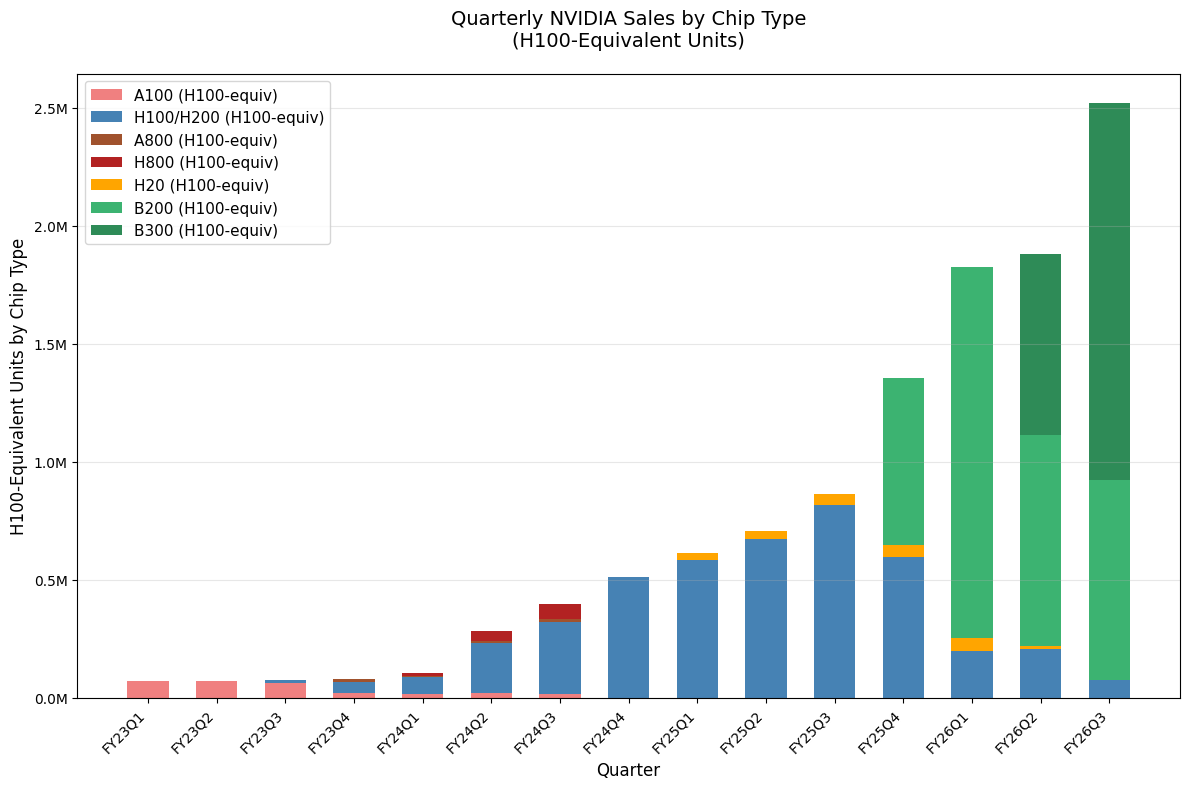

In [ ]:
# Visualization: Quarterly Sales by Chip Type (H100-equivalent units)
# ===================================================================

# Prepare data for quarterly chart
quarters = quarterly_chip_quantities.index.tolist()

# Get median values for each chip type, converted to H100-equivalents
chip_data = {}
for chip in CHIP_TYPES:
    chip_data[chip] = convert_to_h100_equivs(
        chip, 
        quarterly_chip_quantities[f'{chip}_quantity_median'].values
    )

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(quarters))
width = 0.6

# Create stacked bars for each chip type
bottom = np.zeros(len(quarters))

for chip in CHIP_TYPES:
    ax.bar(x, chip_data[chip], width, label=f'{chip} (H100-equiv)', 
           bottom=bottom, color=CHIP_COLORS[chip])
    bottom += chip_data[chip]

# Add line showing total H100-equivalents per quarter
# totals = quarterly_sales['Total_H100_equiv'].values
# ax2 = ax.twinx()
# ax2.plot(x, totals, 'ko-', linewidth=2, markersize=6, label='Total H100-equiv')
# ax2.set_ylabel('Total H100-Equivalent Units', fontsize=12)
# ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Formatting
ax.set_ylabel('H100-Equivalent Units by Chip Type', fontsize=12)
ax.set_xlabel('Quarter', fontsize=12)
ax.set_title('Quarterly NVIDIA Sales by Chip Type\n(H100-Equivalent Units)', 
             fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(quarters, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax.grid(True, alpha=0.3, axis='y')

# Combine legends
lines1, labels1 = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax.legend(lines1 + lines2, labels1 + labels2, fontsize=11, loc='upper left')
ax.legend(lines1, labels1, fontsize=11, loc='upper left')

plt.tight_layout()
plt.savefig("visualizations/quarterly_sales_by_chip.png", dpi=300, bbox_inches="tight")
plt.show()

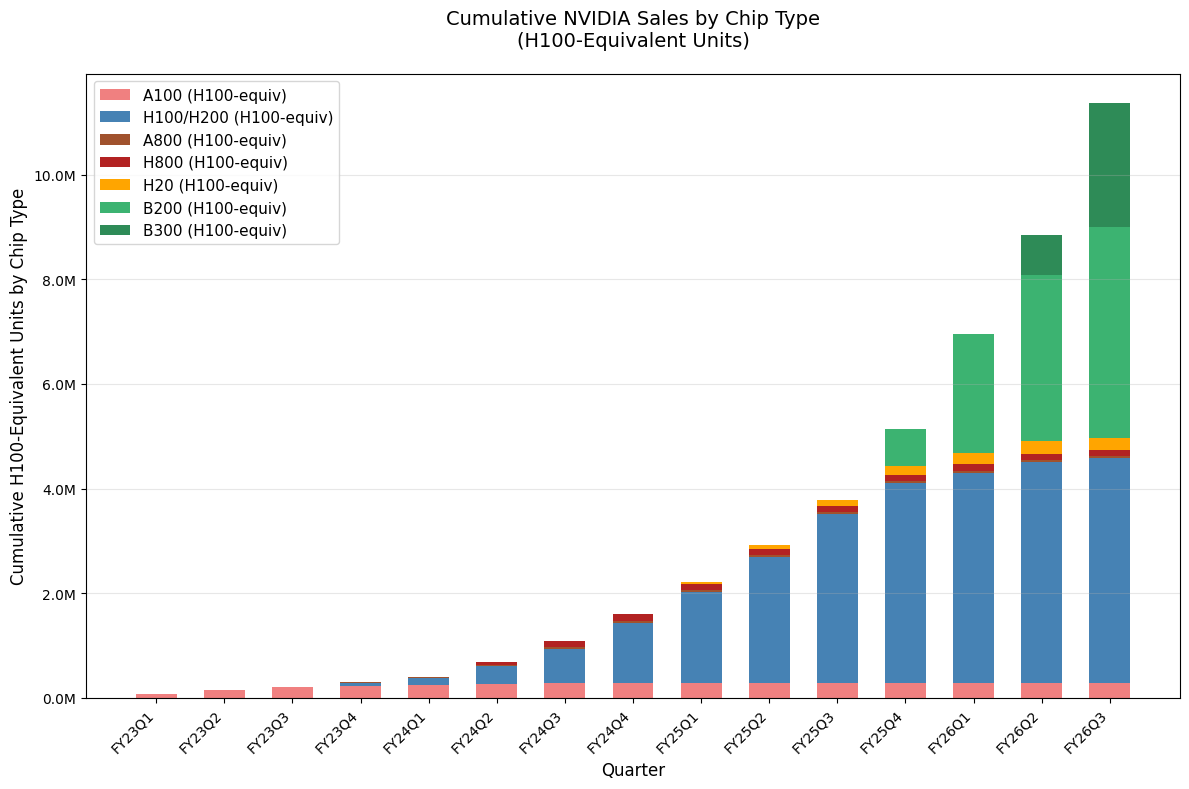

In [79]:
# Cumulative NVIDIA Sales by Chip Type (H100-equivalent units)
# ============================================================================

# Prepare data for cumulative chart
quarters = quarterly_chip_quantities.index.tolist()

# Get median values for each chip type, converted to H100-equivalents
chip_data = {}
for chip in CHIP_TYPES:
    chip_data[chip] = convert_to_h100_equivs(
        chip, 
        quarterly_chip_quantities[f'{chip}_quantity_median'].values
    )

# Calculate cumulative sums for each chip type
chip_data_cumulative = {}
for chip in CHIP_TYPES:
    chip_data_cumulative[chip] = np.cumsum(chip_data[chip])

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(quarters))
width = 0.6

# Create stacked bars for each chip type (cumulative)
bottom = np.zeros(len(quarters))

for chip in CHIP_TYPES:
    ax.bar(x, chip_data_cumulative[chip], width, label=f'{chip} (H100-equiv)', 
           bottom=bottom, color=CHIP_COLORS[chip])
    bottom += chip_data_cumulative[chip]

# Formatting
ax.set_ylabel('Cumulative H100-Equivalent Units by Chip Type', fontsize=12)
ax.set_xlabel('Quarter', fontsize=12)
ax.set_title('Cumulative NVIDIA Sales by Chip Type\n(H100-Equivalent Units)', 
             fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(quarters, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax.grid(True, alpha=0.3, axis='y')

# Add legend
lines1, labels1 = ax.get_legend_handles_labels()
ax.legend(lines1, labels1, fontsize=11, loc='upper left')

plt.tight_layout()
plt.savefig("visualizations/cumulative_sales_by_chip.png", dpi=300, bbox_inches="tight")
plt.show()

In [80]:
quarterly_chip_quantities

,decimal_year,A100_quantity_dist,A100_quantity_median,A100_quantity_5th,A100_quantity_25th,A100_quantity_75th,A100_quantity_95th,H100/H200_quantity_dist,H100/H200_quantity_median,H100/H200_quantity_5th,...,B200_quantity_5th,B200_quantity_25th,B200_quantity_75th,B200_quantity_95th,B300_quantity_dist,B300_quantity_median,B300_quantity_5th,B300_quantity_25th,B300_quantity_75th,B300_quantity_95th
Quarter,,,,,,,,,,,,,,,,,,,,,
FY23Q1,2022.32,<Distribution> 2810000000.0 * lognorm(lognorm_...,226247.638300,170354.339508,199772.442498,250913.149541,290210.326318,None,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY23Q2,2022.57,<Distribution> 2860000000.0 * lognorm(lognorm_...,226776.322131,175451.551793,203729.474215,252827.821054,300539.597655,None,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY23Q3,2022.82,<Distribution> 2583000000.0 * lognorm(lognorm_...,204902.425445,159595.612981,184286.926105,229155.778573,266366.140915,<Distribution> 287000000.00000006 * lognorm(lo...,9735.391119,7103.862426,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY23Q4,2023.07,<Distribution> 843200000.0000001 * lognorm(log...,66968.481274,52007.241958,60175.386732,74520.934499,87693.293338,<Distribution> 1360000000.0 * lognorm(lognorm_...,46054.539994,33735.980313,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY24Q1,2023.32,<Distribution> 703500000.0 * lognorm(lognorm_m...,55962.838067,42848.837582,49975.368754,62546.961042,73040.258858,<Distribution> 2009999999.9999998 * lognorm(lo...,69146.034014,49735.776596,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY24Q2,2023.57,<Distribution> 861000000.0 * lognorm(lognorm_m...,68890.747634,52585.113035,61849.660368,76409.959785,87926.428667,<Distribution> 6113099999.999999 * lognorm(log...,211055.264674,151294.322182,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY24Q3,2023.82,<Distribution> 595000000.0000001 * lognorm(log...,47096.451645,36126.514377,42105.075970,52182.941998,60177.891880,<Distribution> 9044000000.0 * lognorm(lognorm_...,308094.991642,223792.734557,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY24Q4,2024.07,None,0.000000,0.000000,0.000000,0.000000,0.000000,<Distribution> 15070000000.0 * lognorm(lognorm...,511389.102406,362838.040954,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000
FY25Q1,2024.32,None,0.000000,0.000000,0.000000,0.000000,0.000000,<Distribution> 16912800000.0 * lognorm(lognorm...,583408.821028,403087.699524,...,0.000000,0.000000,0.000000,0.000000,None,0.000000,0.000000,0.000000,0.000000,0.000000


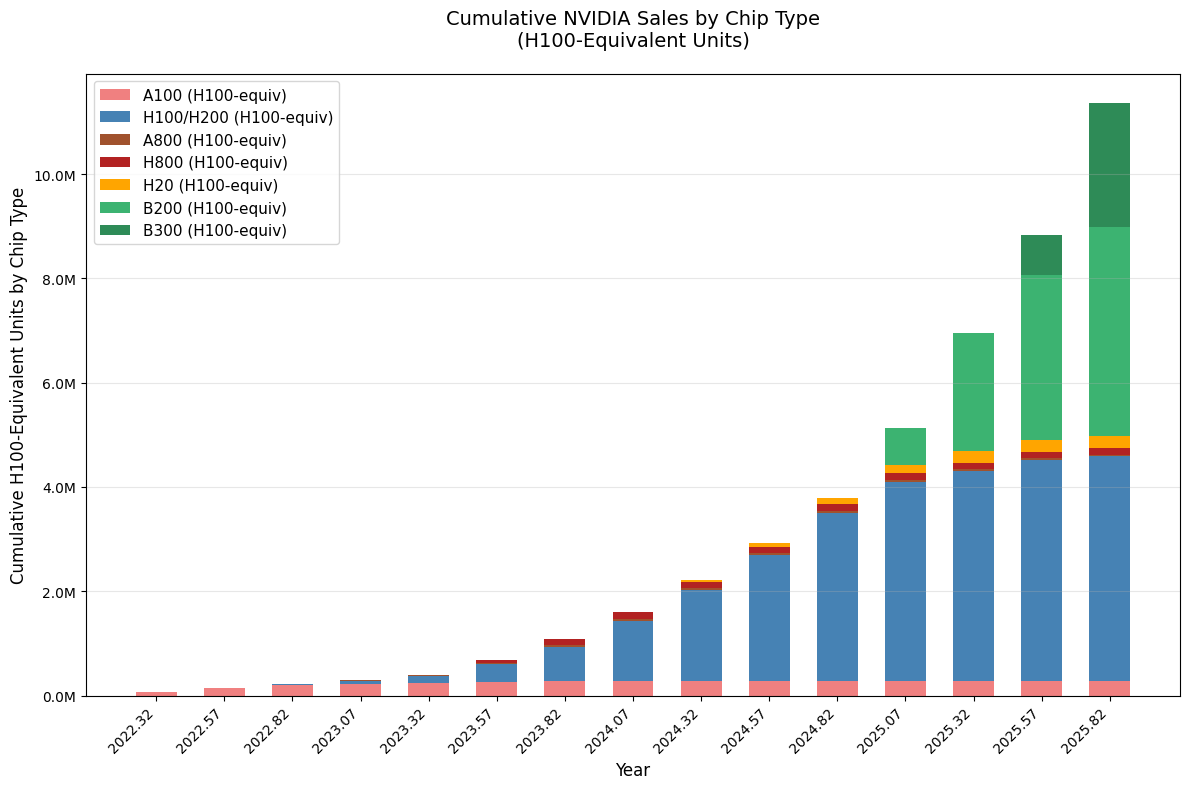

In [81]:
# Cumulative NVIDIA Sales by Chip Type (H100-equivalent units)
# ============================================================================

# Prepare data for cumulative chart
quarters = quarterly_chip_quantities.index.tolist()
decimal_years = quarterly_chip_quantities['decimal_year'].values

# Get median values for each chip type, converted to H100-equivalents
chip_data = {}
for chip in CHIP_TYPES:
    chip_data[chip] = convert_to_h100_equivs(
        chip, 
        quarterly_chip_quantities[f'{chip}_quantity_median'].values
    )

# Calculate cumulative sums for each chip type
chip_data_cumulative = {}
for chip in CHIP_TYPES:
    chip_data_cumulative[chip] = np.cumsum(chip_data[chip])

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(quarters))
width = 0.6

# Create stacked bars for each chip type (cumulative)
bottom = np.zeros(len(quarters))

for chip in CHIP_TYPES:
    ax.bar(x, chip_data_cumulative[chip], width, label=f'{chip} (H100-equiv)', 
           bottom=bottom, color=CHIP_COLORS[chip])
    bottom += chip_data_cumulative[chip]

# Formatting
ax.set_ylabel('Cumulative H100-Equivalent Units by Chip Type', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.set_title('Cumulative NVIDIA Sales by Chip Type\n(H100-Equivalent Units)', 
             fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels([f'{y:.2f}' for y in decimal_years], rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax.grid(True, alpha=0.3, axis='y')

# Add legend
lines1, labels1 = ax.get_legend_handles_labels()
ax.legend(lines1, labels1, fontsize=11, loc='upper left')

plt.tight_layout()
plt.savefig("visualizations/cumulative_sales_decimal_year.png", dpi=300, bbox_inches="tight")
plt.show()


# Prepare data for Airtable import

In [82]:
# Transform data for Airtable
# ============================

from datetime import datetime

# Get current timestamp for notes
timestamp = datetime.now().strftime("%m-%d-%Y %H:%M")
generated_note = f"Date estimates were generated: {timestamp}"

# Transform quarterly sales data
quarterly_sales_copy = quarterly_sales.copy()

# Generate chip mappings dynamically from CHIP_TYPES
# For display, H100/H200 is shortened to H100
def get_display_name(chip):
    """Get display name for a chip type (H100/H200 -> H100)"""
    return 'H100' if chip == 'H100/H200' else chip

def get_column_prefix(chip):
    """Get column prefix for a chip type (remove / from H100/H200)"""
    return chip.replace('/', '')

chip_mappings = [
    (
        get_display_name(chip),
        f'{chip}_quantity',
        f'Total_{get_column_prefix(chip)}_in_H100e',
        f'Total_{get_column_prefix(chip)}_in_H100e_5th',
        f'Total_{get_column_prefix(chip)}_in_H100e_95th'
    )
    for chip in CHIP_TYPES
]

# Create rows for output
rows = []

for quarter, row in quarterly_sales_copy.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']
    
    for chip_type, qty_col, h100e_col, h100e_5th_col, h100e_95th_col in chip_mappings:
        if qty_col in quarterly_sales_copy.columns:
            quantity = row[qty_col]
            h100e_value = row[h100e_col] if h100e_col in quarterly_sales_copy.columns else quantity
            h100e_5th = row[h100e_5th_col] if h100e_5th_col in quarterly_sales_copy.columns else h100e_value
            h100e_95th = row[h100e_95th_col] if h100e_95th_col in quarterly_sales_copy.columns else h100e_value

            # Only include rows where there's actual quantity
            if pd.notna(quantity) and quantity > 0:
                rows.append({
                    'Name': f"{quarter} - {chip_type}",
                    'Chip manufacturer': 'Nvidia',
                    'Start date': start_date,
                    'End date': end_date,
                    'Compute estimate in H100e (median)': int(h100e_value),
                    'H100e (5th percentile)': int(h100e_5th),
                    'H100e (95th percentile)': int(h100e_95th),
                    '# of Units': int(quantity),
                    'Source / Link': '',
                    'Notes': generated_note,
                    'Power estimate (TDP in GW)': '',
                    'Chip type': chip_type,
                    'Last Modified By': '',
                    'Last Modified': '',
                    'Cost estimate (USD)': '',
                    'Select': ''
                })

# Create output dataframe
nvidia_timelines = pd.DataFrame(rows)

# Save to CSV
output_path = 'nvidia_chip_timelines.csv'
nvidia_timelines.to_csv(output_path, index=False)

print(nvidia_timelines[['Name', 'Chip manufacturer', 'Start date', 'End date', 'Compute estimate in H100e (median)', 'H100e (5th percentile)', 'H100e (95th percentile)', 'Chip type']].head(20).to_string())

             Name Chip manufacturer  Start date    End date  Compute estimate in H100e (median)  H100e (5th percentile)  H100e (95th percentile) Chip type
0   FY23Q1 - A100            Nvidia  2022-01-31  2022-05-01                               70980                   53444                    91046      A100
1   FY23Q2 - A100            Nvidia  2022-05-02  2022-07-31                               71146                   55044                    94287      A100
2   FY23Q3 - A100            Nvidia  2022-08-01  2022-10-30                               64283                   50069                    83566      A100
3   FY23Q3 - H100            Nvidia  2022-08-01  2022-10-30                                9735                    7104                    13541      H100
4   FY23Q4 - A100            Nvidia  2022-10-31  2023-01-29                               21010                   16316                    27512      A100
5   FY23Q4 - H100            Nvidia  2022-10-31  2023-01-29           